# HDBSCAN Stop Detection

The HDBSCAN algorithm constructs a hierarchy of non-overlapping clusters from different radius values and selects those that maximize stability.

In [ ]:
%matplotlib inline

# Imports
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import box
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nomad.stop_detection.viz import plot_stops_barcode, plot_time_barcode
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.postprocessing as post

# Load data
city = gpd.read_file("garden_city.geojson").to_crs('EPSG:3857')
outer_box = box(*city.total_bounds).buffer(15, join_style='mitre')

filepath_root = 'gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','==', '2024-01-01'), traj_cols=tc)

user_data_hdb = traj.assign(cluster=HDBSCAN.hdbscan_labels(traj, time_thresh=240, min_pts=3, min_cluster_size=2, traj_cols=tc))
stops_hdb = HDBSCAN.st_hdbscan(traj,
                    time_thresh=720,
                    dist_thresh=15,
                    min_pts=3,
                    complete_output=True,
                    traj_cols=tc)
stops_hdb["cluster"] = post.remove_overlaps(user_data_hdb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)    

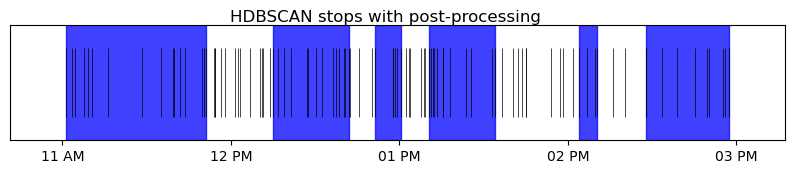

In [30]:
fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_hdb, ax=ax_barcode, stop_color='blue', set_xlim=False, timestamp='unix_ts')
fig.suptitle("HDBSCAN stops with post-processing")
plt.show()